In [25]:
import numpy as np
import pandas as pd
import networkx as nx
import bct as bct
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

### Prepare the network for analysis.

Load the withdrawal correlation matrix.

In [51]:
withdrawal_df = pd.read_csv('../../data/cFosCAN_alcohol_withdrawal_orig_20180326.csv')

Set the index to the region labels.

In [52]:
withdrawal_df = withdrawal_df.set_index('Unnamed: 0')

Sort regions alphabetically.

In [53]:
withdrawal_df = withdrawal_df.sort_index()
withdrawal_df = withdrawal_df.sort_index(axis=1)

In [54]:
withdrawal_mat = withdrawal_df.as_matrix()

Threshold the matrix at a 5% edge density.

In [56]:
np.fill_diagonal(withdrawal_mat, 0)

In [58]:
withdrawal_95pctl = stats.scoreatpercentile(withdrawal_mat, 95)

In [59]:
withdrawal_95pctl_mask = (withdrawal_mat <= withdrawal_95pctl)

In [60]:
withdrawal_mat[withdrawal_95pctl_mask] = 0

Createa a data frame for the thresholded matrix.

In [65]:
withdrawal_95pctl_df = pd.DataFrame(withdrawal_mat)

Add column and index labels back in.

In [71]:
withdrawal_95pctl_df.columns = withdrawal_df.columns[:]

In [77]:
withdrawal_95pctl_df.index = withdrawal_df.index

Drop regions that have been disconnected during thresholding

In [86]:
disconnected_regions = (withdrawal_95pctl_df != 0).any(axis=0)

In [93]:
withdrawal_95pctl_cc_df = withdrawal_95pctl_df.loc[disconnected_regions,disconnected_regions]

Save the connected component of the network as a matrix.

In [175]:
np.savetxt('../../data/cFosCAN_alcohol_withdrawal_95pctl_CC_mat_20180423.csv', withdrawal_95pctl_cc_df.as_matrix(), delimiter=',')

### Prepare the manual partition.

Load the manual partition.

In [19]:
manual_partition_df = pd.read_csv('../../data/ClusterBrainListForGraphTheory.csv')

Set the index to the region labels.

In [22]:
manual_partition_df = manual_partition_df.set_index("Region")

Sort regions alphabetically.

In [24]:
manual_partition_df = manual_partition_df.sort_index()

Get an array containing module assignments for nodes in the connected component.

In [111]:
cc_partition = manual_partition_df.iloc[disconnected_regions.values,2].values

### Draw the connected (thresholded) graph.

Build a graph object.

In [94]:
G = nx.from_numpy_matrix(withdrawal_95pctl_cc_df.as_matrix())

In [139]:
node_strength = bct.degree.strengths_und(withdrawal_95pctl_cc_df.as_matrix())

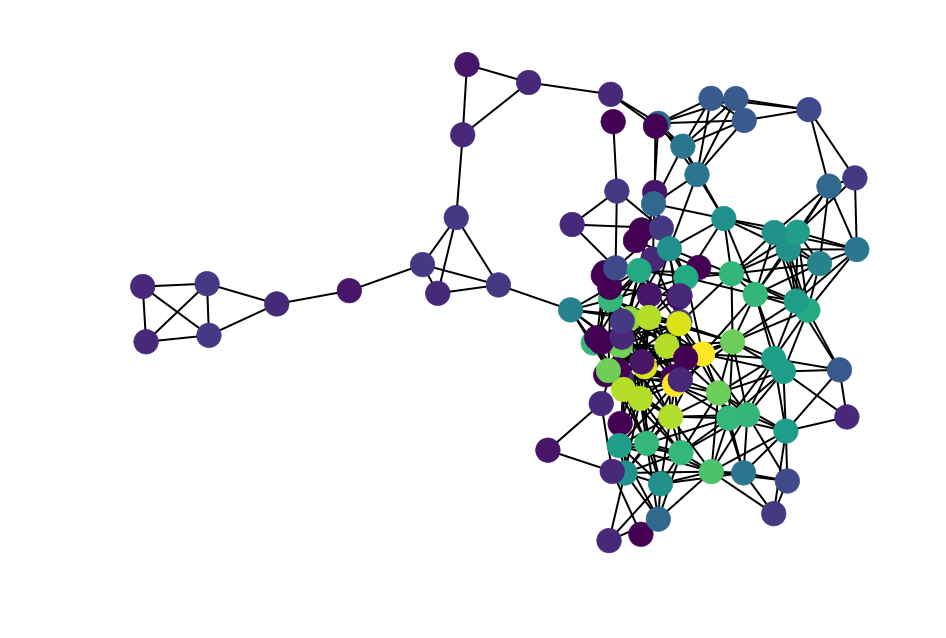

In [149]:
nx.draw_kamada_kawai(G, node_color=node_strength, node_size=150, cmap=plt.cm.viridis)

### Calculate and plot nodal metrics based on the manual partition.

Draw the graph with nodes colored by module.

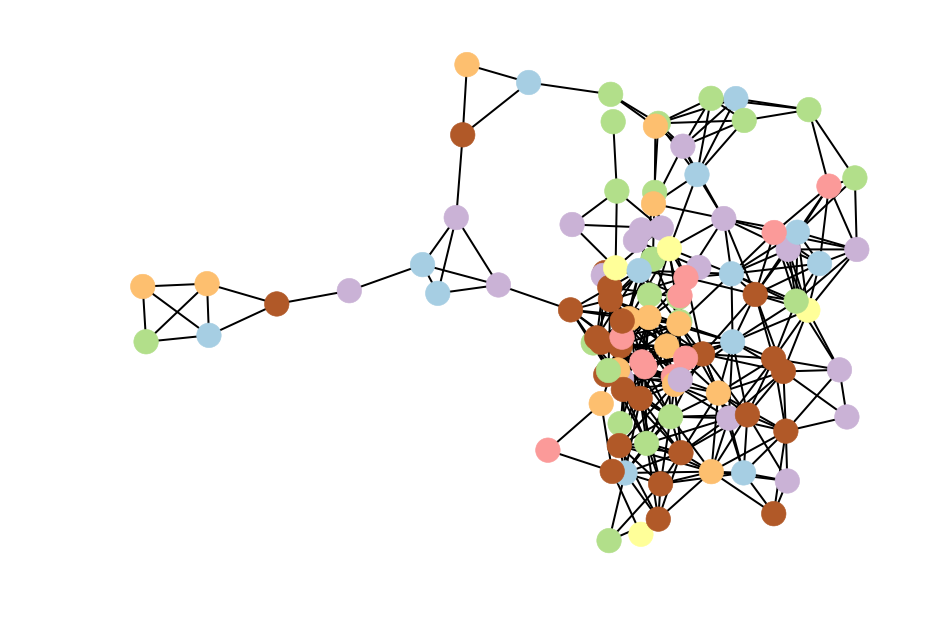

In [133]:
nx.draw_kamada_kawai(G, node_color=cc_partition, node_size=150, cmap=plt.cm.Paired)

Calculate nodal metrics and draw the graph with nodes colored by each metric.

In [206]:
manual_pc = bct.centrality.participation_coef(withdrawal_95pctl_cc_df.as_matrix(), cc_partition)

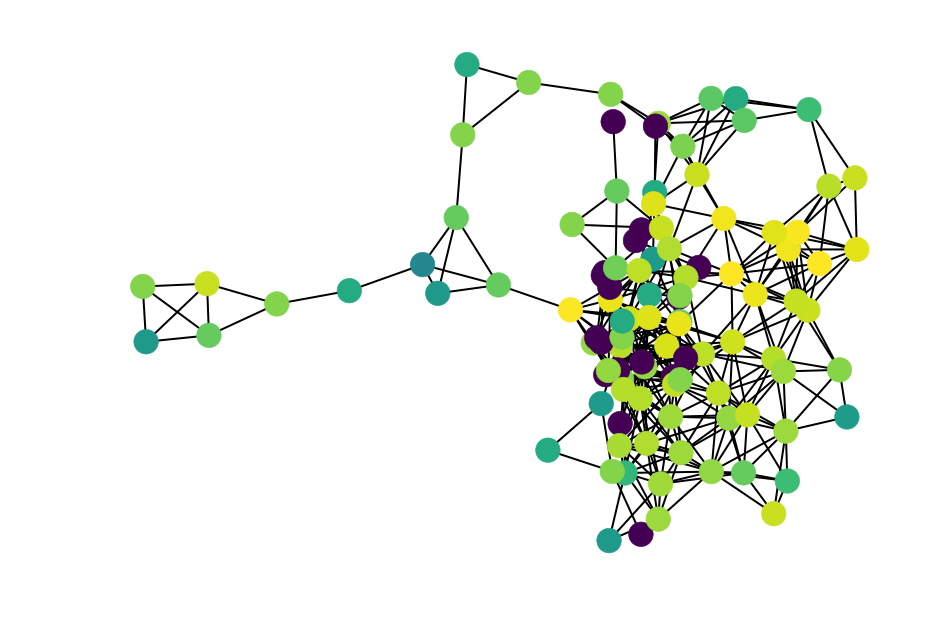

In [207]:
nx.draw_kamada_kawai(G, node_color=manual_pc, node_size=150, cmap=plt.cm.viridis)

In [208]:
manual_wmdz = bct.centrality.module_degree_zscore(withdrawal_95pctl_cc_df.as_matrix(), cc_partition)

/home/despoB/dlurie/anaconda3/envs/sandbox/lib/python3.5/site-packages/bct/algorithms/centrality.py:642: RuntimeWarning: invalid value encountered in true_divide
  Z[np.where(ci == i)] = (Koi - np.mean(Koi)) / np.std(Koi)


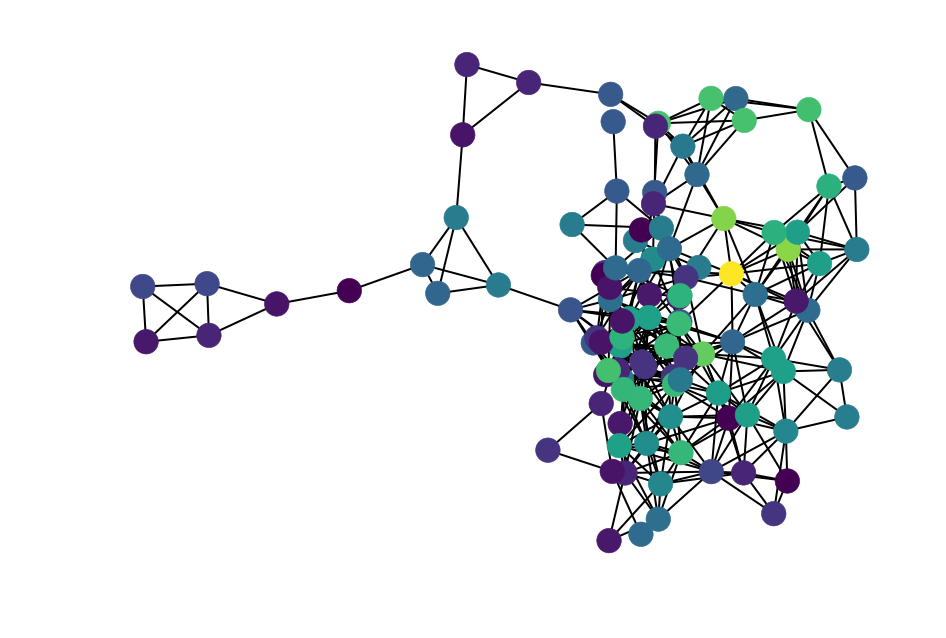

In [209]:
nx.draw_kamada_kawai(G, node_color=manual_wmdz, node_size=150, cmap=plt.cm.viridis)

### Visualize data-driven nodal metrics and partition.
These were calculated using the `run_louvain.m` Matlab script and gamma=1.4.

Plot the matrix re-ordered by module.

In [184]:
dd_reordered_matrix = np.genfromtxt('/home/despoB/dlurie/Projects/withdrawal_CAN/results/withdrawal_95pctl/20180423_ReorderedMatrix.txt')

In [185]:
dd_reordered_matrix = dd_reordered_matrix.reshape(withdrawal_95pctl_cc_df.shape)

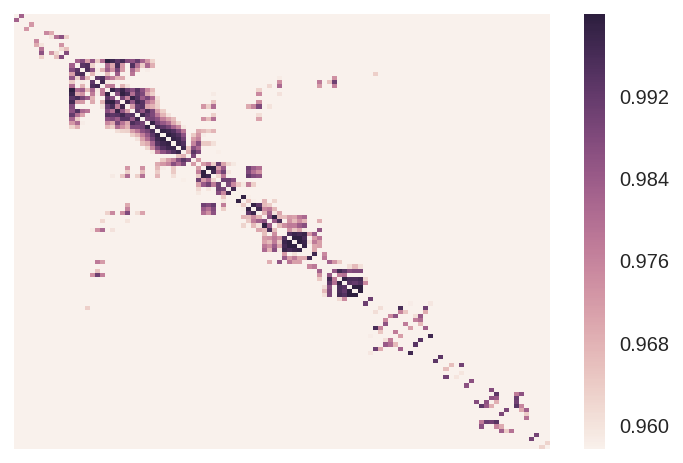

In [195]:
sns.heatmap(dd_reordered_matrix, xticklabels=False, yticklabels=False, vmin=withdrawal_95pctl)

Draw the graph colored by module.

In [196]:
dd_partition = np.genfromtxt('/home/despoB/dlurie/Projects/withdrawal_CAN/results/withdrawal_95pctl/20180423_GraphPartition.txt')

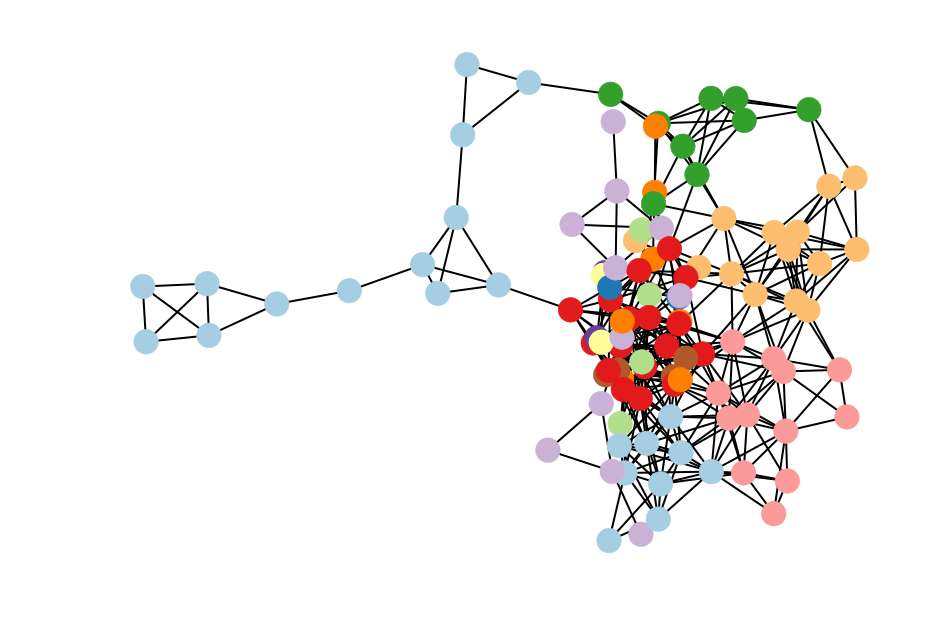

In [198]:
nx.draw_kamada_kawai(G, node_color=dd_partition, node_size=150, cmap=plt.cm.Paired)

Draw the graph with nodes colored by PC.

In [199]:
dd_pc = np.genfromtxt('/home/despoB/dlurie/Projects/withdrawal_CAN/results/withdrawal_95pctl/20180423_PC.txt')

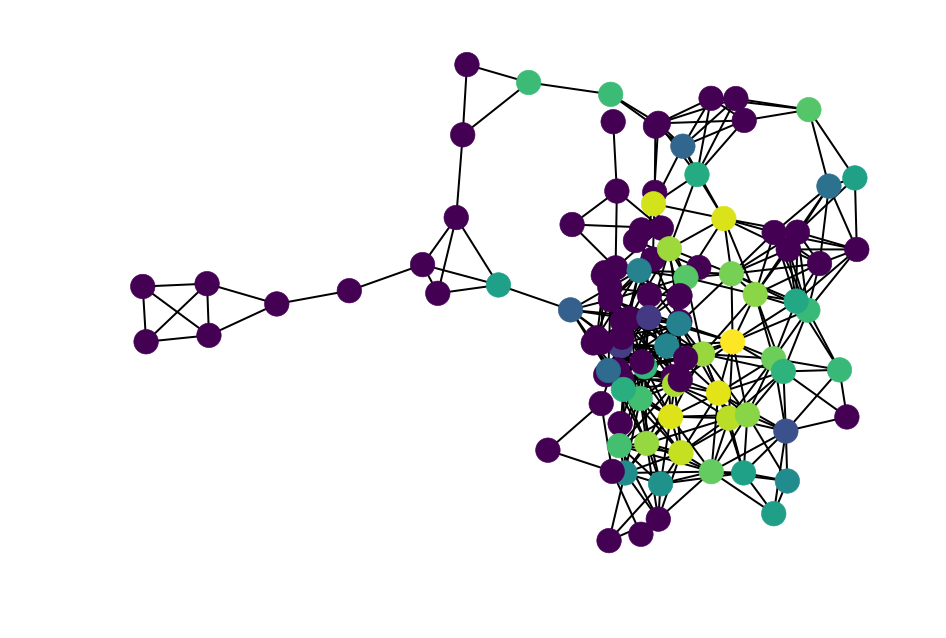

In [200]:
nx.draw_kamada_kawai(G, node_color=dd_pc, node_size=150, cmap=plt.cm.viridis)

Draw the graph with nodes colored by WMDz.

In [201]:
dd_wmdz = np.genfromtxt('/home/despoB/dlurie/Projects/withdrawal_CAN/results/withdrawal_95pctl/20180423_WMDz.txt')

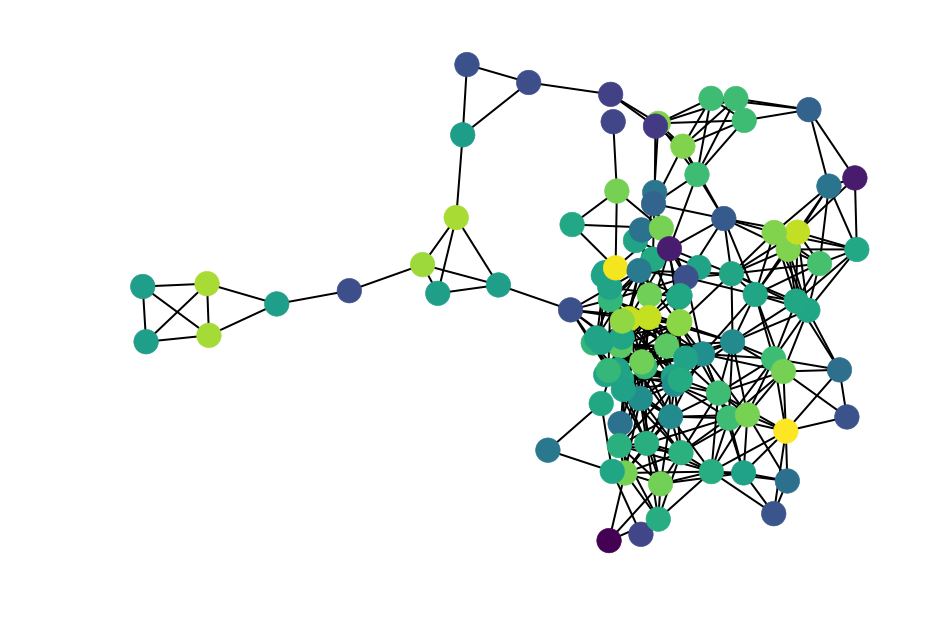

In [202]:
nx.draw_kamada_kawai(G, node_color=dd_wmdz, node_size=150, cmap=plt.cm.viridis)

Combine all our results into a single spreadsheet.

In [222]:
combined_df = pd.DataFrame(np.array([node_strength, cc_partition, manual_pc, manual_wmdz, dd_partition, dd_pc, dd_wmdz]).T,
                           columns=['node_strength', 'manual_partition', 'manual_pc', 'manual_wmdz', 'dd_partition','dd_pc', 'dd_wmdz'])

In [225]:
combined_df = combined_df.set_index(manual_partition_df.iloc[disconnected_regions.values,2].index)

Save the combined spreadsheet to disk.

In [227]:
combined_df.to_csv('/home/despoB/dlurie/Projects/withdrawal_CAN/results/withdrawal_95pctl/20180423_combined_results.csv', sep=',')